In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# use sixel backend
# matplotlib.use("module://matplotlib-backend-sixel")

# make default font size larger
plt.rcParams.update({"font.size": 32})

# make default line width larger
plt.rcParams.update({"axes.linewidth": 4})
plt.rcParams.update({"lines.linewidth": 4})
plt.rcParams.update({"grid.linewidth": 4})

# make default figure size larger
plt.rcParams.update({"figure.figsize": (10, 8)})

# make default markers larger
plt.rcParams.update({"lines.markersize": 20})

# Sample NxN matrix $J$ with stats:
$\mathbb{E}[J] = 0$

$\mathbb{E}[J_{ij}^2] = 1/N$

$\mathbb{E}[J_{ij}J_{ji}] = \tau / N, \forall i \neq j$


In [2]:
def sample_matrix(N=50, num_samples=1000, tau=0.5):
    """
    Generate num_samples number of random NxN asymmetric matrix.

    The correlation between J_ij and J_ji is tau.
    The mean of each element is 0.
    The variance of each element is 1.

    Returns:
        J: np.ndarray of shape (N, N, num_samples)
        mean_diff: maximum difference between the mean of J and 0
        std_diff: maximum difference between the std of J and 1
        corr_diff: maximum difference between the correlation of J and tau
        tol: tolerance for the differencek
    """
    # generate a random matrix
    A = np.random.randn(N, N, num_samples) / np.sqrt(N)
    At = np.transpose(A, (1, 0, 2))

    # some quick maffs to get the desired correlation
    a = np.sqrt((1 + tau))
    b = np.sqrt((1 - tau))
    alpha = 0.5 * (a + b)
    beta = 0.5 * (a - b)
    J = alpha * A + beta * At

    # resample the diagonal elements
    J[np.diag_indices(N)] = np.random.randn(N, num_samples) / np.sqrt(N)

    # compute empirical statistics
    Jt = np.transpose(J, (1, 0, 2))
    means = np.mean(J, axis=2)
    stds = np.mean(J * J, axis=2)
    corrs = np.mean(J * Jt, axis=2)
    expected = (tau + np.eye(N) * (1 - tau)) / N

    tol = 10 * np.sqrt(1 / num_samples)
    mean_diff = np.max(np.abs(means))
    std_diff = np.max(np.abs(stds - 1.0 / N))
    corr_diff = np.max(np.abs(corrs - expected))

    print(
        f"mean_diff={mean_diff:.2e}, std_diff={std_diff:.2e}, "
        + f"corr_diff={corr_diff:.2e}, tol={tol:.2e}"
    )

    return J, mean_diff, std_diff, corr_diff, tol

Checking num_samples=10
mean_diff=1.72e-01, std_diff=5.12e-02, corr_diff=2.85e-02, tol=3.16e+00
Checking num_samples=21
mean_diff=1.10e-01, std_diff=2.64e-02, corr_diff=2.10e-02, tol=2.18e+00
Checking num_samples=46
mean_diff=7.97e-02, std_diff=1.60e-02, corr_diff=1.30e-02, tol=1.47e+00
Checking num_samples=100
mean_diff=4.53e-02, std_diff=9.89e-03, corr_diff=8.65e-03, tol=1.00e+00
Checking num_samples=215
mean_diff=3.26e-02, std_diff=7.67e-03, corr_diff=5.27e-03, tol=6.82e-01
Checking num_samples=464
mean_diff=2.33e-02, std_diff=4.88e-03, corr_diff=3.60e-03, tol=4.64e-01
Checking num_samples=1000
mean_diff=1.53e-02, std_diff=3.17e-03, corr_diff=2.59e-03, tol=3.16e-01
Checking num_samples=2154
mean_diff=1.10e-02, std_diff=2.06e-03, corr_diff=1.56e-03, tol=2.15e-01
Checking num_samples=4641
mean_diff=7.33e-03, std_diff=1.78e-03, corr_diff=1.21e-03, tol=1.47e-01
Checking num_samples=10000
mean_diff=4.42e-03, std_diff=1.15e-03, corr_diff=7.98e-04, tol=1.00e-01


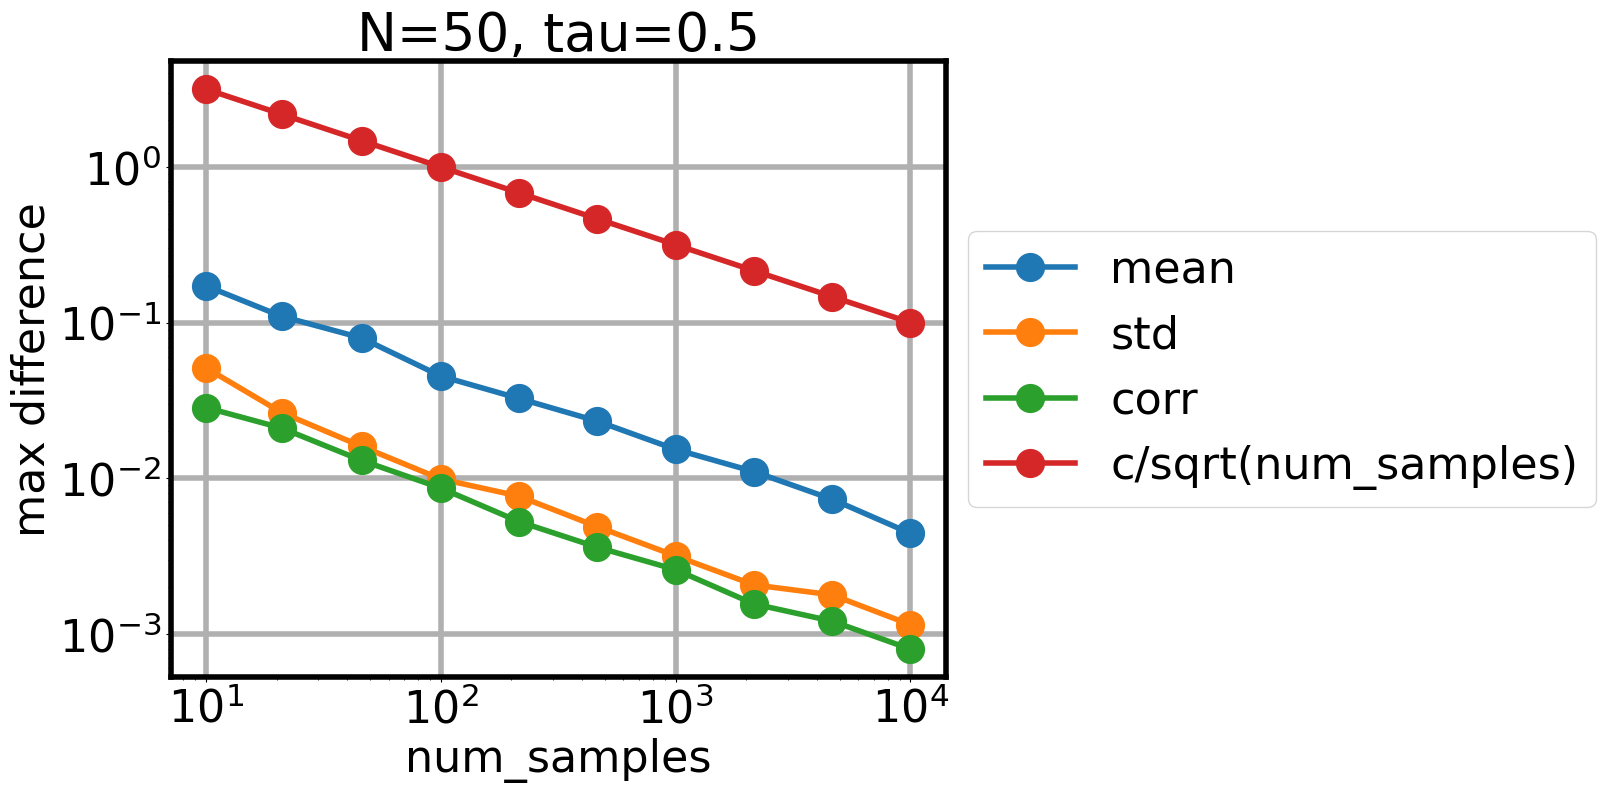

In [3]:
# check stats
mean_diffs = []
std_diffs = []
corr_diffs = []
tols = []

N = 50
tau = 0.5
num_samples = np.logspace(1, 4, 10).astype(int)
for num_sample in num_samples:
    print(f"Checking num_samples={num_sample}")
    J, mean_diff, std_diff, corr_diff, tol = sample_matrix(
        num_samples=num_sample,
        N=N,
        tau=tau,
    )
    mean_diffs.append(mean_diff)
    std_diffs.append(std_diff)
    corr_diffs.append(corr_diff)
    tols.append(tol)

plt.figure()
plt.grid()
plt.plot(num_samples, mean_diffs, "o-", label="mean")
plt.plot(num_samples, std_diffs, "o-", label="std")
plt.plot(num_samples, corr_diffs, "o-", label="corr")
plt.plot(num_samples, tols, "o-", label="c/sqrt(num_samples)")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("num_samples")
plt.ylabel("max difference")
plt.title(f"N={N}, tau={tau}")
# plot legend outside of the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# Compute spectrum and histogram on complex plane

In [4]:
def histogram_spectrum(J, bins=100, extent=5.0):
    """
    Compute the spectrum of the NxN matrix J.

    Returns:
        spectrum: np.ndarray of shape (N, num_samples)
    """
    # compute the eigenvalues
    N = J.shape[0]
    spectrum = np.linalg.eigvals(J.transpose(2, 0, 1))
    real = np.real(spectrum).reshape(-1)
    imag = np.imag(spectrum).reshape(-1)

    H, xedges, yedges = np.histogram2d(real, imag, bins=bins, density=True)

    x = xedges[:-1] + 0.5 * (xedges[1] - xedges[0])
    y = yedges[:-1] + 0.5 * (yedges[1] - yedges[0])

    xx, yy = np.meshgrid(x, y)

    # contour plot of the histogram
    plt.figure()
    plt.contourf(xx, yy, H.T, levels=bins, cmap="viridis")
    plt.xlabel("real")
    plt.ylabel("imag")
    plt.title(f"Spectrum of J, tau={tau}, N={N}")
    plt.xlim(extent, -extent)
    plt.ylim(extent, -extent)
    plt.colorbar()
    plt.show()

    return spectrum

mean_diff=3.85e-02, std_diff=5.93e-03, corr_diff=3.85e-03, tol=1.00e+00


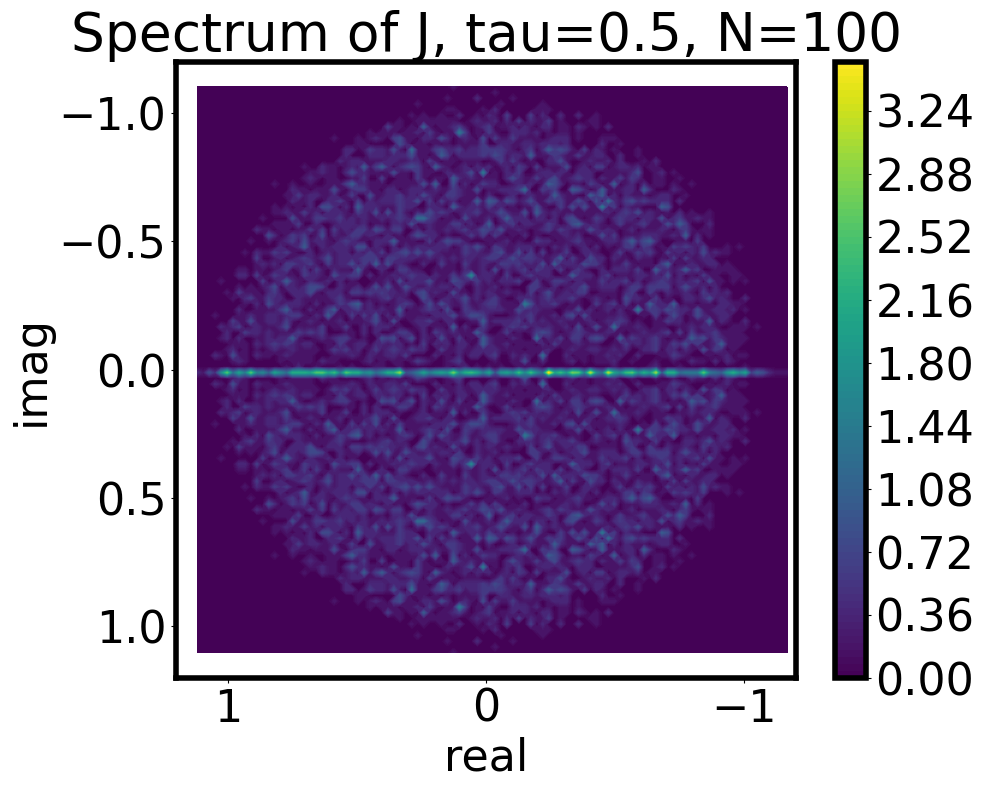

In [5]:
# sample matrix
J, _, _, _, _ = sample_matrix(N=100, num_samples=100, tau=0.0)

# compute spectrum
spectrum = histogram_spectrum(J, extent=1.2)